Data Pre-processing

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

df = pd.read_csv("EasyVisa.csv")
print(df.shape)

(25480, 12)


Data cleaning

In [4]:
# check null values
features_with_na = [feature for features in df.columns if df[features].isnull().sum() >= 1]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), "% missing values")

features_with_na

[]

In [5]:
# handling duplicates

df.duplicated().sum()

np.int64(0)

In [6]:
# remove case_id

df.drop("case_id", inplace=True, axis=1)

In [9]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [7]:
from datetime import date

todays_date = date.today()
current_year = todays_date.year

In [8]:
df["company_age"] = current_year - df["yr_of_estab"]
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


In [9]:
df.drop("yr_of_estab", inplace=True, axis=1)

Types of features

In [10]:
# Numeric features
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print(f"Number of Numeric features : {len(num_features)}")

Number of Numeric features : 3


In [11]:
# Categorical features
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(f"Number of Categorical features : {len(cat_features)}")

Number of Categorical features : 8


In [12]:
# Discrete features
discrete_features = [feature for feature in num_features if len(df[feature].unique()) <= 25]
print(f"Number of Discrete features : {len(discrete_features)}")

Number of Discrete features : 0


In [13]:
# Continuous features
continuous_features = [feature for feature in num_features if len(df[feature].unique()) > 25]
print(f"Number of Continuous features : {len(continuous_features)}")

Number of Continuous features : 3


Split X and Y

In [14]:
X = df.drop("case_status", axis=1)
y = df["case_status"]

In [15]:
# encode the target column
y = np.where(y == "Denied", 1, 0)

In [16]:
y

array([1, 0, 1, ..., 0, 0, 0], shape=(25480,))

Feature transformation

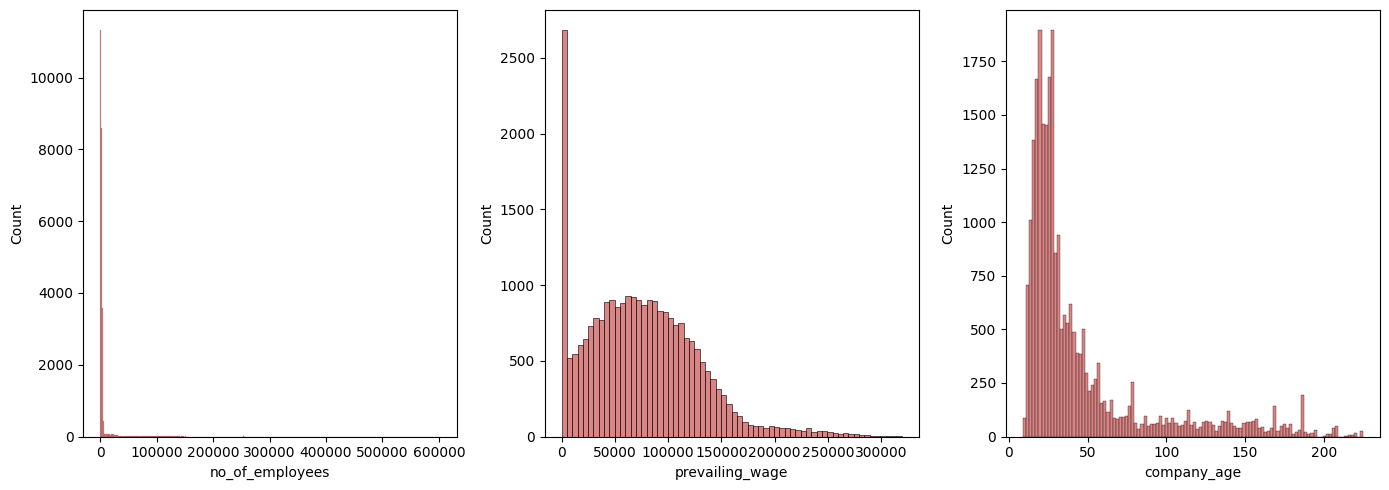

In [17]:
#distribution of data before scaling
plt.figure(figsize=(14, 5))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(1, 3, i+1)
    sns.histplot(x = X[col], color = "indianred")
    plt.xlabel(col)
    plt.tight_layout()

In [18]:
# check skew
X[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

In [19]:
# applying power transform to reduce the outliers
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

X_copy = pd.DataFrame(X_copy, columns=transform_features)

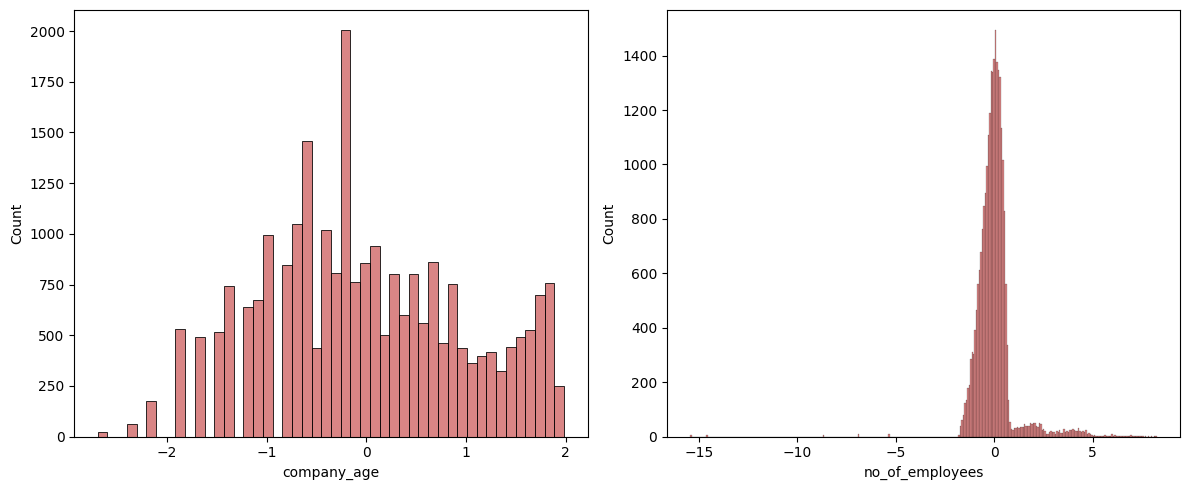

In [20]:
plt.figure(figsize=(12,5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color="indianred")
    plt.xlabel(col)
    plt.tight_layout()

In [21]:
# check the skew of the transformed features
X_copy.skew(axis=0, skipna = True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

In [22]:
for feature in cat_features:
    print(feature, ":", df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


Feature Encoding and Scaling

In [23]:
num_features = list(X.select_dtypes(exclude='object').columns)
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [24]:
# preprocessing using column transformer
# create column transformer with 3 types of transformers

or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns = ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps = [('transformer', PowerTransformer(method = 'yeo-johnson'))])
preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, or_columns),
        ('Ordinal_Encoder', ordinal_encoder, or_columns),
        ('Transformer', transform_pipe, transform_columns),
        ('StandardScaler', numeric_transformer, num_features)
    ]
)

In [25]:
X = preprocessor.fit_transform(X)
X

array([[ 1.        ,  0.        ,  1.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  1.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 1.        ,  0.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  1.        , ..., -0.10805575,
        -0.06776315,  0.45814768]], shape=(25480, 19))

In [26]:
# classification

from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class
smt = SMOTEENN(random_state = 42, sampling_strategy = 'minority')
X_res, y_res = smt.fit_resample(X, y)

Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

#separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=42) 
X_train.shape, X_test.shape

((12364, 19), (3091, 19))

In [28]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [39]:
# create a function that will evaluate the models and return a report

def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    models_list = []
    accuracy_list = []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # train the model

        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, \
            model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)

        # test set perfromance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, \
            model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')

    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by = ['Accuracy'], ascending = False)

    return report


Model Training

In [40]:
base_model_report = evaluate_models(X = X_res, y = y_res, models = models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9363
- F1 score: 0.9421
- Precision: 0.9342
- Recall: 0.9502
- Roc Auc Score: 0.9348


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9049
- F1 score: 0.9139
- Precision: 0.9038
- Recall: 0.9242
- Roc Auc Score: 0.9029


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8598
- F1 score: 0.8697
- Precision: 0.8932
- Recall: 0.8474
- Roc Auc Score: 0.8612
----------------------------------
Model performance for Test set
- Accuracy: 0.8534
- F1 score: 0.8623
- Precision: 0.8857
- Recall: 0.8400
- Roc Auc Score: 0.8548


Logistic Regression
Model performance for Training 

In [41]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.936267
4,K-Neighbors Classifier,0.928179
1,Decision Tree,0.904885
5,XGBClassifier,0.901650
6,CatBoosting Classifier,0.898738
2,Gradient Boosting,0.853445
7,Support Vector Classifier,0.850210
3,Logistic Regression,0.835328
8,AdaBoost Classifier,0.831770


In [42]:
# Random forest for hyper parameter tuning

# initialize parameters for hyperparameter tuning
xgboost_params = {
    'max_depth':range(3, 10, 2),
    'min_child_weight':range(1, 6, 2)
}

rf_params = {
    'max_depth': [10, 12, None, 15, 20],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 50, 100, 200]
}

knn_params = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5, 6, 7, 9]
}

In [43]:
# models list for hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ('RF', RandomForestClassifier(), rf_params),
    ('KNN', KNeighborsClassifier(), knn_params)
]

In [45]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator = model,
                                    param_distributions = params,
                                    n_iter = 100,
                                    cv = 3,
                                    verbose = 2,
                                    n_jobs = 1)

    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"Best params for {model_name}")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_ch

In [46]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': None, 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}}

In [48]:
# Retrain the model with best parameters

from sklearn.metrics import roc_auc_score, roc_curve
best_models = {
    'Random Forest Classifier': RandomForestClassifier(**model_param['RF']),
    'KNeinghbors Classifier': KNeighborsClassifier(**model_param['KNN']),
    'XGBClassifier': XGBClassifier(**model_param['XGBoost'], n_jobs = 1)
}

tuned_report = evaluate_models(X = X_res, y = y_res, models = best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9376
- F1 score: 0.9434
- Precision: 0.9348
- Recall: 0.9520
- Roc Auc Score: 0.9361


KNeinghbors Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9605
- F1 score: 0.9644
- Precision: 0.9500
- Recall: 0.9793
- Roc Auc Score: 0.9586


XGBClassifier
Model performance for Training set
- Accuracy: 0.9971
- F1 score: 0.9974
- Precision: 0.9965
- Recall: 0.9982
- Roc Auc Score: 0.9970
----------------------------------
Model performance for Test set
- Accuracy: 0.9330
- F1 score: 0.9391
- Precision: 0.9328
- Recall: 0.9455
- Roc Auc Score: 0.9318




In [49]:
tuned_report

,Model Name,Accuracy
1,KNeinghbors Classifier,0.960531
0,Random Forest Classifier,0.937561
2,XGBClassifier,0.933031


In [51]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9605
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1403
           1       0.95      0.98      0.96      1688

    accuracy                           0.96      3091
   macro avg       0.96      0.96      0.96      3091
weighted avg       0.96      0.96      0.96      3091



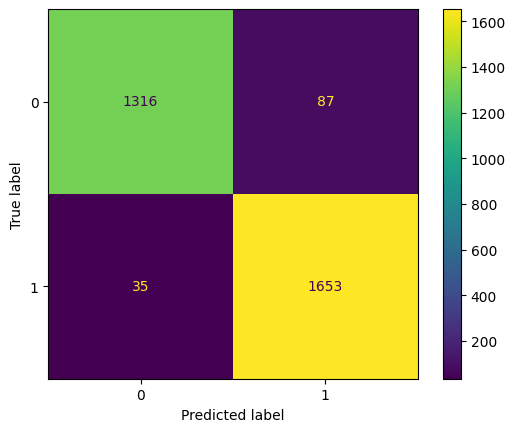

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test) 